# part 1 : the snowplow problem

A snowplow must clean the snow in front of 1000 houses. The position of each house is represented by a float number (not necessary positive). Initially, the snow- plow is in 0. The traveling time of the snowplow is equivalent to the distance that it went through since the beginning of the day. If there are several houses at the same point, it does not take a longer time to clean the snow (the snow is cleaned as soon as the snowplow has passed). However, since the positions of the houses are represented as floats, this should not happen often.

The snowplow must minimize the average waiting time before the snow is clea- ned in front of the houses, from the point of view of the houses.

Conventions : You must write a function that takes has input the positions of the 1000 houses, and outputs the positions of the houses, sorted in the same order as they are cleaned.

In [33]:
# for inline plots in jupyter
%matplotlib inline
# import matplotlib
import matplotlib.pyplot as plt
# for latex equations
from IPython.display import Math, Latex
# for displaying images
from IPython.core.display import Image

import pandas as pd
import numpy as np

In [34]:
!pip install seaborn

You should consider upgrading via the 'pip install --upgrade pip' command.


In [35]:
# import seaborn
import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(5,5)})

## Part 1: Generating different test set
I'm going to put some random test set into a pandas DataFrame to test my function on different use cases

In [36]:
houseDf = pd.DataFrame()

### Different random distribution for different test sets

The goal in this part is to generate diffenrent sets of houses for testing purposes

    1.Uniform Distribution
Since any interval of numbers of equal width has an equal probability of being observed, the curve describing the distribution is a rectangle, with constant height across the interval and 0 height elsewhere. Since the area under the curve must be equal to 1, the length of the interval determines the height of the curve. The following figure shows a uniform distribution in interval (a,b). Notice since the area needs to be 1
. The height is set to 1/(b−a)
.

In [37]:
# import uniform distribution
from scipy.stats import uniform

In [38]:
# random numbers from uniform distribution
n = 1000
start = -100
end = 100
width = end - start
data_uniform = uniform.rvs(size=n, loc = start, scale=width)
houseDf['uniform'] = data_uniform

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Uniform Distribution ')]

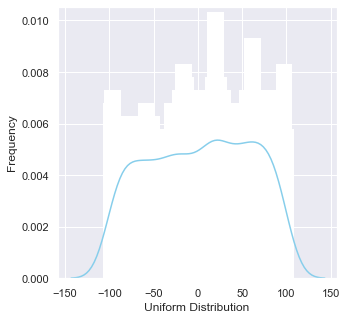

In [39]:
ax = sns.distplot(data_uniform,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Uniform Distribution ', ylabel='Frequency')

    2.Normal distribution

A normal distribution has a bell-shaped density curve described by its mean μ
 and standard deviation σ
. The density curve is symmetrical, centered about its mean, with its spread determined by its standard deviation showing that data near the mean are more frequent in occurrence than data far from the mean.


In [40]:
from scipy.stats import norm
# generate random numbers from N(0,1)
data_normal = norm.rvs(size=n,loc=start,scale=width)
houseDf['normal'] = data_normal

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Normal Distribution')]

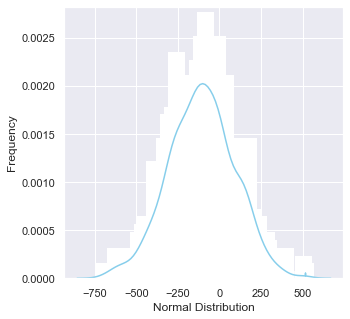

In [41]:
ax = sns.distplot(data_normal,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Normal Distribution', ylabel='Frequency')

    3 Gamma distribution
The gamma distribution is a two-parameter family of continuous probability distributions. While it is used rarely in its raw form but other popularly used distributions like exponential, chi-squared, erlang distributions are special cases of the gamma distribution. The gamma distribution can be parameterized in terms of a shape parameter α=k
 and an inverse scale parameter β=1/θ
, called a rate parameter., the symbol Γ(n)
 is the gamma function and is defined as (n−1)!


In [42]:
from scipy.stats import gamma
data_gamma = gamma.rvs(a=5, size=n)
houseDf['gamma'] = data_gamma

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Gamma Distribution')]

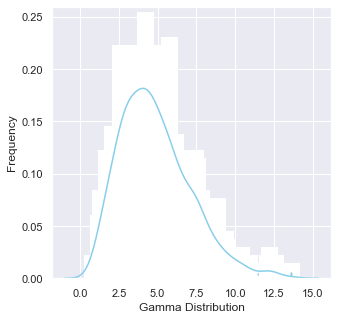

In [43]:
ax = sns.distplot(data_gamma,
                  kde=True,
                  bins=100,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1})
ax.set(xlabel='Gamma Distribution', ylabel='Frequency')


    4. Homemade sinuzoid distribution
The goal here is to create multiple sinuozoids to test some sinuzoid houses distribution

In [44]:
def generate_sinewave(length = 1000, frequency = 2, amplitude = 100):
    x = np.linspace(0, frequency * np.pi, length)
    sinewave = np.sin(x) * amplitude
    return sinewave

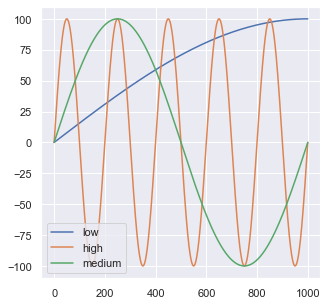

In [45]:
houseDf['sinewave_lowf'] = generate_sinewave(frequency = 0.5)
houseDf['sinewave_highf'] = generate_sinewave(frequency = 10)
houseDf['sinewave_mediumf'] = generate_sinewave(frequency = 2)
plt.plot(houseDf['sinewave_lowf'], label='low')
plt.plot(houseDf['sinewave_highf'], label='high')
plt.plot(houseDf['sinewave_mediumf'], label='medium')
plt.legend()

## Part 2: algorithm

### Time evaluation function
First thing first: we must create the function that will evaluate the performance of the algorithms by actually do the snow cleaning :)

In [109]:
import math

def evaluate(houseArray):
    lastPosition = 0
    distance = 0
    for house in houseArray:
        distance += abs(house - lastPosition)
        lastPosition = house
    return distance

def evaluateWaitingAverage(houseArray):
    waitingTimes = []
    lastPosition = 0
    distance = 0
    for house in houseArray:
        distance += abs(house - lastPosition)
        lastPosition = house
        waitingTimes.append(distance)
    return np.average(waitingTimes)
    

Now let's test the evaluation function on two cases

In [110]:
# as the cleaner begins at position 0, this should return 4
testCaseA = [1, 2, 3, 4]
print(f"Simple distance evaluation should output 4, output: {evaluate(testCaseA)}")
print(f"Mean waiting time evaluation should output 2.5, output: {evaluateWaitingAverage(testCaseA)}")

Simple distance evaluation should output 4, output: 4
Mean waiting time evaluation should output 2.5, output: 2.5


In [111]:
print(abs(0 - 150) + abs(-150 - 3) + abs(125 - 3))
testCaseB = [-150, 3, 125]
print(f"Simple distance evaluation should output 425, output: {evaluate(testCaseB)}")
print(f"Mean waiting time evaluation should output 2.5, output: {evaluateWaitingAverage(testCaseB)}")

# the two prints must be the same

425
Simple distance evaluation should output 425, output: 425
Mean waiting time evaluation should output 2.5, output: 292.6666666666667


### Greedy algorithm
Let's write the greedy algorithm that looks like what must have been written by M.lehir

In [112]:
# from: https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# way faster thanks to the use of searchsorted
def find_nearest_sorted(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

In [113]:
# this only goes to the closest house without looking further 
def greedy_baseline(houseArray):
    # let's sort the array for optimization matter
    houseArray = np.sort(houseArray)
    currentPos = 0
    result = []
    while len(houseArray) > 0:
        nearestIdx = find_nearest_sorted(houseArray, currentPos)
        nearest = houseArray[nearestIdx]
        result.append(nearest)
        currentPos = nearest
        houseArray = np.delete(houseArray, nearestIdx)
        
    return result

In [114]:
#let's try this on a normal distribution
houseArray = np.random.normal(0,1000,1000).tolist()

resultArray = greedy_baseline(np.array(houseArray))
resultDistance = evaluate(resultArray)
resultTimesFromHousePoV = evaluateWaitingAverage(houseArray)
print(resultDistance)
print(resultTimesFromHousePoV)

9577.10182316424
539774.016964862


#### Let's try this baseline on every distribution

In [118]:
# creating a dataframe to hold the results
resultDf = pd.DataFrame(({"distributions": houseDf.columns}))
resultDf.set_index("distributions")
resultDf

,distributions
0,uniform
1,normal
2,gamma
3,sinewave_lowf
4,sinewave_highf
5,sinewave_mediumf


In [119]:
resultDf['base_distance'] = [evaluate(greedy_baseline(np.array(houseDf[column]))) for column in houseDf]
resultDf['base_waitingMean'] = [evaluateWaitingAverage(greedy_baseline(np.array(houseDf[column]))) for column in houseDf]


resultDf

,distributions,base_distance,base_waitingMean
0,uniform,298.890159,154.281659
1,normal,1936.283233,577.553687
2,gamma,13.665377,4.856347
3,sinewave_lowf,100.000000,63.648302
4,sinewave_highf,299.999629,163.398139
5,sinewave_mediumf,299.999629,163.398139


In [ ]:
def _alphabeta(houseArray, currentPos, currentDistance):
    nearestIdx = find_nearest_sorted(houseArray, currentPos)
    nearest = houseArray[nearestIdx]
    result.append(nearest)
    currentPos = nearest
    houseArray = np.delete(houseArray, nearestIdx)

def alphabeta(houseArray):
    houseArray = np.sort(houseArray)
    return _alphabeta(houseArray, 0, 0)

